In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from tqdm import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
from concurrent.futures import ProcessPoolExecutor, as_completed
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
def preprocess_images(images, target_size=(300, 300)):
    preprocessed_images = []
    for img in images:
        if img.shape[:2] != target_size:
            img = cv.resize(img, target_size)
        if len(img.shape) == 2: 
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        if img.shape[2] == 4: 
            img = cv.cvtColor(img, cv.COLOR_BGRA2BGR)
        if img.shape[2] != 3: 
            img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
        preprocessed_images.append(img)
    return np.array(preprocessed_images)

In [3]:
def display_sample(images, labels):
    unique_labels = list(set(labels))
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))
    
    for i, label in enumerate(unique_labels):
        idx = labels.index(label)
        img = images[idx]
        
        if img.dtype == np.float32 or img.dtype == np.float64:
            img = np.clip(img, 0, 1)
        else:
            img = np.clip(img, 0, 255).astype(np.uint8)
        
        axes[i].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        axes[i].set_title(label)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
def insertGambar(folder):
    data = []
    datalabel = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        for filename in tqdm(os.listdir(label_folder)):
            img_path = os.path.join(label_folder, filename)
            img = plt.imread(img_path)
            if img is not None:
                data.append(img)
                datalabel.append(label)
    return data, datalabel

In [6]:
def rotasi(image, derajat):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, derajat, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

In [7]:
def augmentasi(data, labels, banyakData):
    augmented_data = []
    augmented_labels = []
    for i in tqdm(range(len(data))):
        augmented_data.append(data[i])
        augmented_labels.append(labels[i])
        for j in range(banyakData):
            if j % 2 == 0:
                rotated_90 = rotasi(data[i], 90)
                augmented_data.append(rotated_90)
                augmented_labels.append(labels[i])
            elif j % 2 == 1:
                rotated_minus_90 = rotasi(data[i], -90)
                augmented_data.append(rotated_minus_90)
                augmented_labels.append(labels[i])
    augmented_filenames = [f"{label}_augmented_{idx}" for idx, label in enumerate(augmented_labels)]
    return augmented_data, augmented_filenames, augmented_labels

In [8]:
data, label = insertGambar("Sea Animal")
print("Data: ", len(data))
print("Label: ", len(label))

100%|██████████| 200/200 [00:00<00:00, 494.24it/s]

Data:  1150
Label:  1150


In [9]:
dataResize = preprocess_images(data, target_size=(300, 300))
augmented_data, augmented_filenames, augmented_labels = augmentasi(dataResize, label, 2)
print("Jumlah total dataset setelah augmentasi:", len(augmented_data))


100%|██████████| 1150/1150 [00:04<00:00, 241.74it/s]

Jumlah total dataset setelah augmentasi: 3450


In [10]:
def grayscale(data):
    dataGray = []
    for img in data:
        if len(img.shape) == 3:
            gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        else:
            gray = img
        dataGray.append(gray)
    return dataGray

def threshold(data):
    thresholdData = []
    for img in data:
        _, threshed_img = cv.threshold(img, 127, 255, cv.THRESH_BINARY)
        threshed_img = threshed_img.astype(np.uint8)
        thresholdData.append(threshed_img)
    return thresholdData

def edge_detection(data):
    edgeData = []
    for img in data:
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)
        edges = cv.Canny(img, 100, 200)
        edgeData.append(edges)
    return edgeData

def contour_detection(data):
    contourData = []
    for img in data:
        contours, _ = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contour_img = np.zeros_like(img)
        cv.drawContours(contour_img, contours, -1, (255, 255, 255), 1)
        contourData.append(contour_img)
    return contourData


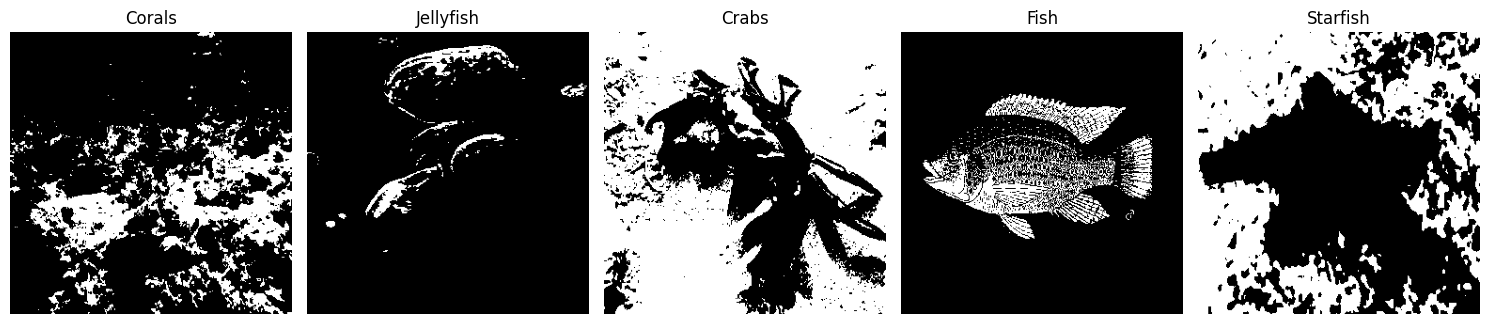

In [11]:
dataGray = grayscale(augmented_data)
dataThreshold = threshold(dataGray)
display_sample(dataThreshold, augmented_labels)

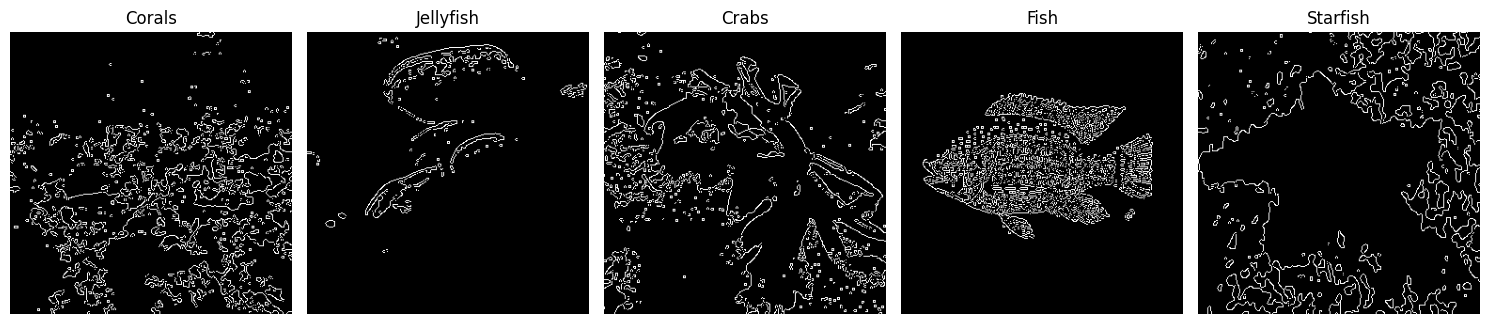

In [12]:
dataEdges = edge_detection(dataThreshold)
display_sample(dataEdges, augmented_labels)

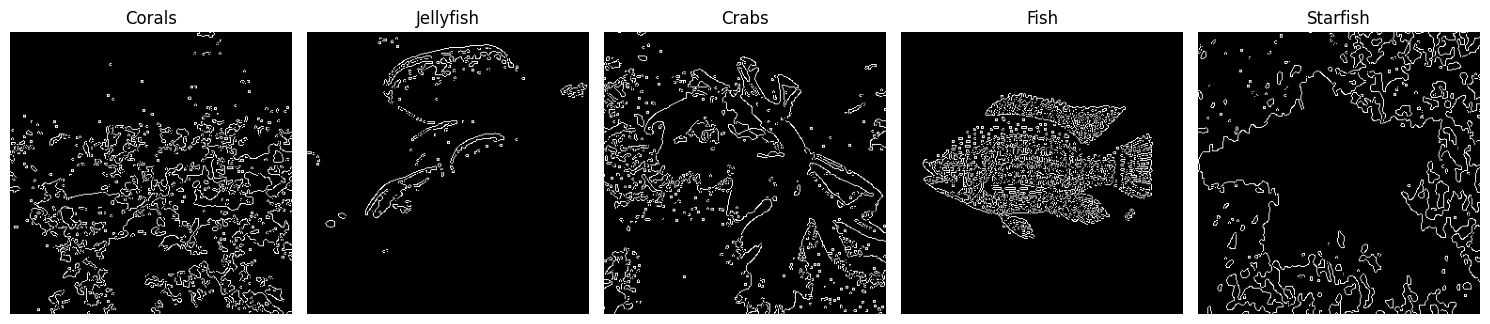

In [13]:
dataContours = contour_detection(dataEdges)
display_sample(dataContours, augmented_labels)

In [17]:
def contrast(data):
    return np.sum(data * (np.arange(data.shape[0])[:, None] - np.arange(data.shape[1])) ** 2)

def dissimilarity(data):
    return np.sum(data * np.abs(np.arange(data.shape[0])[:, None] - np.arange(data.shape[1])))

def homogeneity(data):
    return np.sum(data / (1.0 + (np.arange(data.shape[0])[:, None] - np.arange(data.shape[1])) ** 2))

def energy(data):
    return np.sum(data ** 2)

def correlation(data):
    mean = np.zeros((2))
    std = np.zeros((2))
    for i in range(len(data)):
        for j in range(len(data[0])):
            mean[0] += i * data[i, j]
            mean[1] += j * data[i, j]
    for i in range(len(data)):
        for j in range(len(data[0])):
            std[0] += (i - mean[0]) ** 2 * data[i, j]
            std[1] += (j - mean[1]) ** 2 * data[i, j]
    std[0] = np.sqrt(std[0])
    std[1] = np.sqrt(std[1])
    hasil = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            hasil += (i - mean[0]) * (j - mean[1]) * data[i, j] / (std[0] * std[1])
    return hasil

def entropy(data):
    entropy = 0
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] > 0.0:
                entropy += -(data[i][j] * math.log(data[i][j]))
    return entropy

def asm(data):
    return np.sum(data ** 2)

def derajat(image, derajat):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv.getRotationMatrix2D(center, derajat, 1.0)
    rotated = cv.warpAffine(image, M, (w, h))
    return rotated

def ekstraksi(dataContours):
    hasil = []
    for img in tqdm(dataContours):
        data = []
        data.append(derajat(img, 0))
        data.append(derajat(img, 45))
        data.append(derajat(img, 90))
        data.append(derajat(img, 135))
        hasil.append(data)
    return hasil


In [18]:
hasil = ekstraksi(dataContours)

  0%|          | 0/3450 [00:00<?, ?it/s]

100%|██████████| 3450/3450 [00:23<00:00, 146.80it/s]


In [19]:

def extract_features_for_image(img_set, idx):
    extracted_data = [f"file_{idx}"]
    for img in img_set:
        extracted_data.append(contrast(img))
    for img in img_set:
        extracted_data.append(dissimilarity(img))
    for img in img_set:
        extracted_data.append(homogeneity(img))
    for img in img_set:
        extracted_data.append(energy(img))
    for img in img_set:
        extracted_data.append(correlation(img))
    for img in img_set:
        extracted_data.append(entropy(img))
    for img in img_set:
        extracted_data.append(asm(img))
    return extracted_data

def parallel_feature_extraction(hasil, num_threads=8):
    results = []
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(extract_features_for_image, hasil[i], i) for i in range(len(hasil))]
        for future in tqdm(as_completed(futures), total=len(futures)):
            results.append(future.result())
    return results


In [20]:
num_threads = 8 
result = parallel_feature_extraction(hasil, num_threads=num_threads)

  9%|▉         | 327/3450 [36:21<4:45:08,  5.48s/it] C:\Users\harma\AppData\Local\Temp\ipykernel_1460\2901355537.py:29: RuntimeWarning: invalid value encountered in scalar divide
  hasil += (i - mean[0]) * (j - mean[1]) * data[i, j] / (std[0] * std[1])
 14%|█▎        | 469/3450 [51:45<5:28:22,  6.61s/it] 

In [ ]:
angles = ['0', '45', '90', '135']
fiturs = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'entropy', 'asm']
columns = ['filename'] + [f"{f}_{a}" for f in fiturs for a in angles]
df = pd.DataFrame(result, columns=columns)

In [ ]:
df.to_csv("P1_ekstraksi_fitur.csv", index=False)

Train Tes Split data

In [ ]:
from sklearn.impute import SimpleImputer

X = df.drop(['filename'], axis=1)
y = augmented_labels

print("Number of NaNs in X:", X.isna().sum().sum())

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

Number of NaNs in X: 212


Normalisasi

In [ ]:
scaler = StandardScaler()
X_train_balanced = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

Modeling

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(X_train_balanced, y_train_encoded)
y_pred_knn = knn.predict(X_test)
print('Accuracy (KNN):', accuracy_score(y_test_encoded, y_pred_knn))

Accuracy (KNN): 0.5449275362318841


In [ ]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(X_train_balanced, y_train_encoded)
y_pred_svm = svm.predict(X_test)
print('Accuracy (SVM):', accuracy_score(y_test_encoded, y_pred_svm))

Accuracy (SVM): 0.527536231884058


In [ ]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(X_train_balanced, y_train_encoded)
y_pred_rfc = rfc.predict(X_test)
print('Accuracy (RF):', accuracy_score(y_test_encoded, y_pred_rfc))

Accuracy (RF): 0.691304347826087


In [ ]:
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}

df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())

for model_name, model in model_dict.items():
    y_pred = model.predict(X_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test_encoded, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test_encoded, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test_encoded, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test_encoded, y_pred, average='weighted')



Evaluasi

In [ ]:
print(df_eval)

     Accuracy Precision    Recall  F1 Score
KNN  0.544928  0.538967  0.544928   0.53929
SVM  0.527536  0.516103  0.527536  0.510629
RF   0.691304  0.687119  0.691304  0.686287


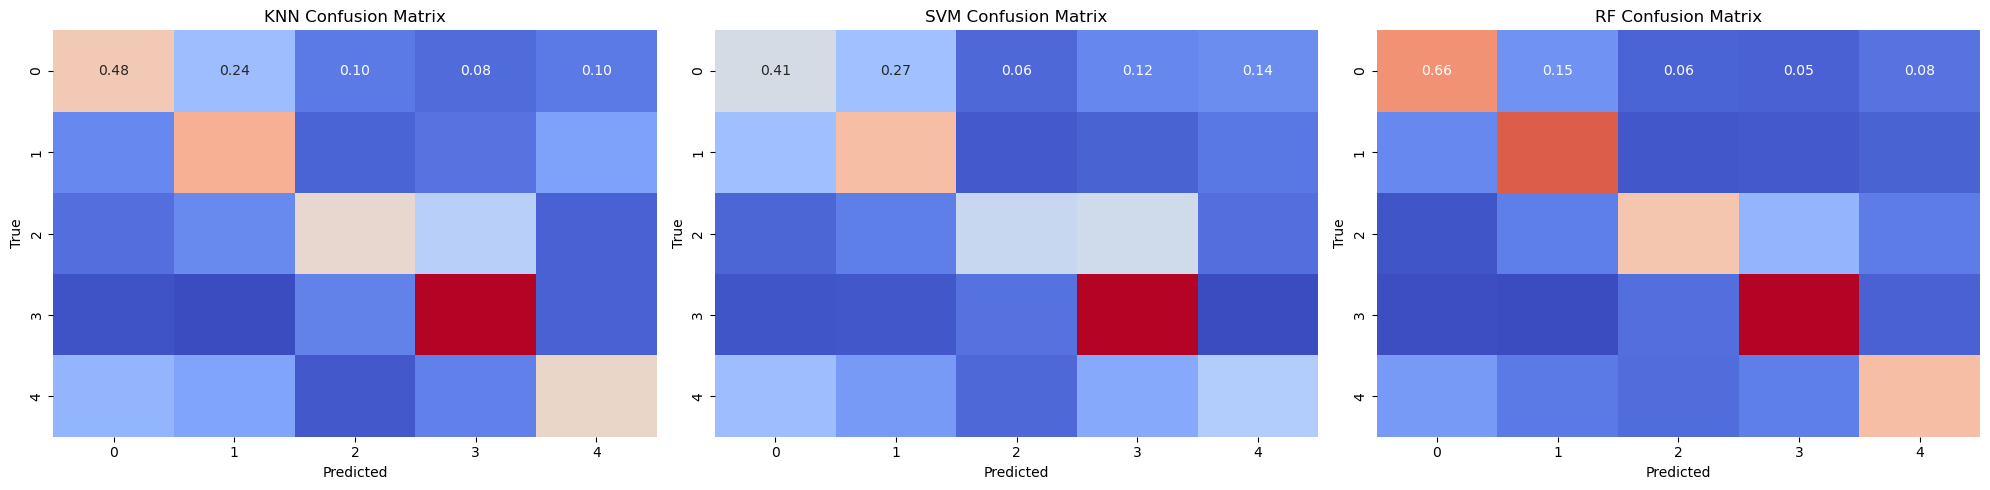

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, (model_name, model) in enumerate(model_dict.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test_encoded, y_pred, labels=np.unique(y_test_encoded))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(f'{model_name} Confusion Matrix')

plt.tight_layout()
plt.show()

In [14]:
X_cnn = np.array(dataContours)
X_cnn = np.expand_dims(X_cnn, axis=-1) 

encoder = LabelEncoder()
y_cnn_encoded = encoder.fit_transform(augmented_labels)

X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y_cnn_encoded, test_size=0.2, random_state=42)

X_cnn_train = X_cnn_train / 255.0
X_cnn_test = X_cnn_test / 255.0

In [15]:

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 1)), 
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_cnn_encoded)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\HAPPY COM\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
cnn_history = cnn_model.fit(X_cnn_train, y_cnn_train, epochs=10, validation_data=(X_cnn_test, y_cnn_test))

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.3380 - loss: 1.9491 - val_accuracy: 0.4275 - val_loss: 1.2842
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.4538 - loss: 1.2615 - val_accuracy: 0.5377 - val_loss: 1.1441
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.6106 - loss: 0.9844 - val_accuracy: 0.5696 - val_loss: 1.0918
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7560 - loss: 0.6308 - val_accuracy: 0.5580 - val_loss: 1.2116
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8677 - loss: 0.3699 - val_accuracy: 0.5638 - val_loss: 1.2859
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.8878 - loss: 0.2895 - val_accuracy: 0.5638 - val_loss: 1.5263
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9159 - loss: 0.2174 - val_accuracy: 0.5623 - val_loss: 1.5717
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9364 - loss: 0.1791 - val_accuracy: 0.5406 - val_loss

In [17]:
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_cnn_test, y_cnn_test)
y_cnn_pred = cnn_model.predict(X_cnn_test)
y_cnn_pred_classes = np.argmax(y_cnn_pred, axis=1)

print("Accuracy CNN:", cnn_accuracy)
print(classification_report(y_cnn_test, y_cnn_pred_classes))

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - accuracy: 0.5401 - loss: 2.0246
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step
Accuracy CNN: 0.5536231994628906
              precision    recall  f1-score   support

           0       0.46      0.39      0.42       145
           1       0.55      0.65      0.59       140
           2       0.65      0.41      0.50       120
           3       0.65      0.76      0.70       172
           4       0.44      0.50      0.47       113

    accuracy                           0.55       690
   macro avg       0.55      0.54      0.54       690
weighted avg       0.56      0.55      0.55       690



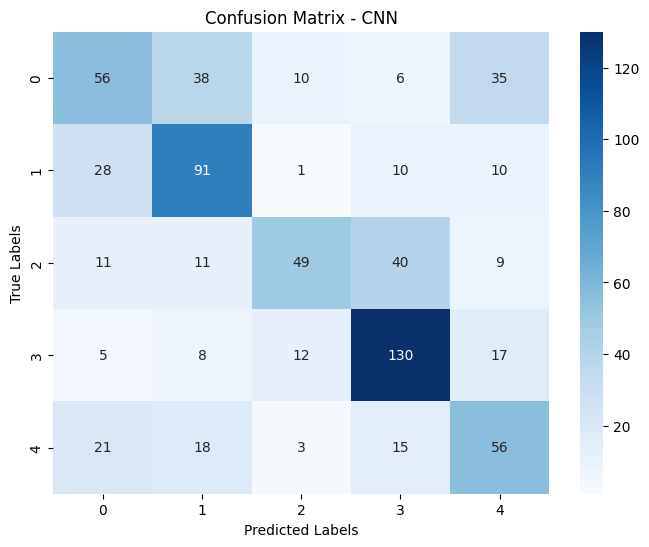

In [18]:
conf_matrix_cnn = confusion_matrix(y_cnn_test, y_cnn_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN')
plt.show()

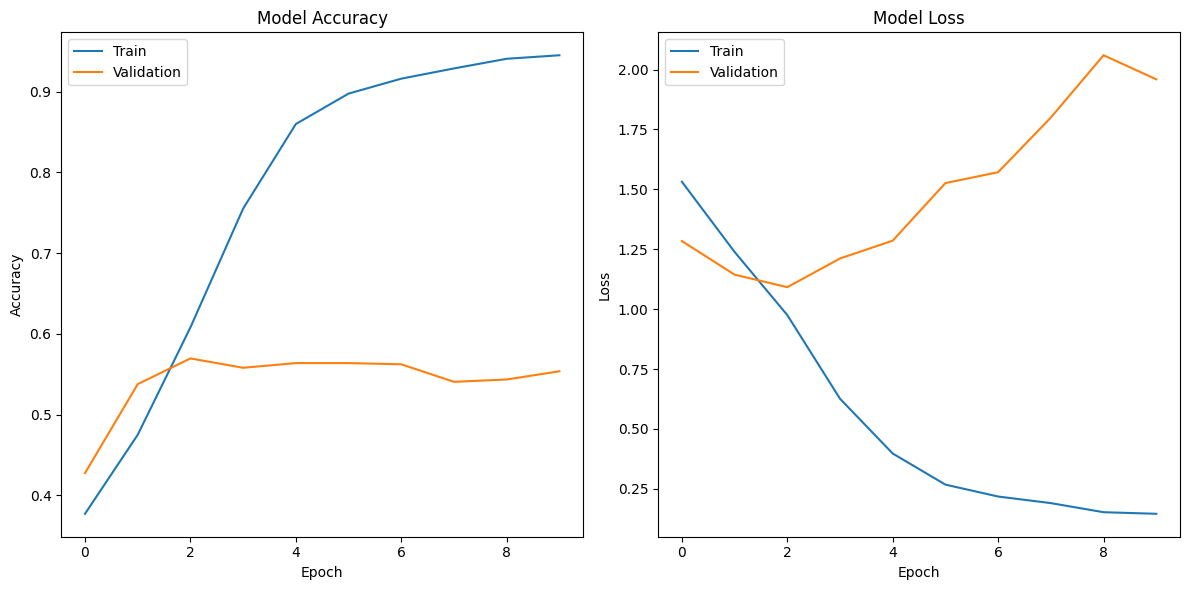

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()